# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

### Set up Analysis

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [6]:
frac_infect = pd.read_csv(config['mAb_neuts'], index_col=0)

In [7]:
frac_infect

,serum,virus,replicate,concentration,fraction infectivity
0,LyCoV555,very low,1,0.166667,0.000002
1,LyCoV555,very low,1,0.041667,0.003510
2,LyCoV555,very low,1,0.010417,0.099252
3,LyCoV555,very low,1,0.002604,0.513108
4,LyCoV555,very low,1,0.000651,0.850309
...,...,...,...,...,...
187,4A8,high,2,0.002604,1.140743
188,4A8,high,2,0.000651,0.979990
189,4A8,high,2,0.000163,0.950808
190,4A8,high,2,0.000041,0.985863


## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [8]:
fits = neutcurve.CurveFits(frac_infect, fixbottom= False, fixtop= True)

In [9]:
fitparams = (
        fits.fitParams()
        # get columns of interest
        [['serum', 'ic50', 'ic50_bound','virus']]
        .assign(NT50=lambda x: 1/x['ic50'])        
        )

In [10]:
cat_order = ['very low', 'low', 'medium', 'high']
fitparams['virus'] = pd.Categorical(fitparams['virus'], categories=cat_order, ordered=True)

In [11]:
fitparams

,serum,ic50,ic50_bound,virus,NT50
0,LyCoV555,0.002520,interpolated,very low,396.764998
1,LyCoV555,0.003043,interpolated,low,328.656981
2,LyCoV555,0.004048,interpolated,medium,247.026726
3,LyCoV555,0.015075,interpolated,high,66.334383
4,S309,0.011144,interpolated,very low,89.731906
5,S309,0.022513,interpolated,low,44.419146
6,S309,0.031744,interpolated,medium,31.501638
7,S309,6.000000,lower,high,0.166667
8,4A8,0.005148,interpolated,very low,194.232873
9,4A8,0.006607,interpolated,low,151.363779


In [12]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


## Plot neut curves for mAbs

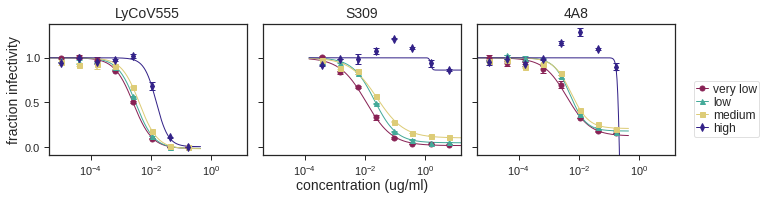

In [13]:
#not sure about color, but at least I managed to change them! When I indicate colors this way, does it pick from the cbpalatte?
fig, axes = fits.plotSera(
                          viruses=['very low', 'low', 'medium', 'high'],
                          xlabel='concentration (ug/ml)',
                          ncol=6,
                          widthscale=1,
                          heightscale=1,
                          titlesize=14, labelsize=14, ticksize=11, legendfontsize=12, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1,
                          virus_to_color_marker={
                              'very low': ('#882255', 'o'),
                              'low': ('#44AA99', '^'),
                              'medium': ('#DDCC77', 's'),
                              'high': ('#332288', 'd')},
                          sharex=True
                         )